## Load PACKAGE

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

## CHARGE DATA

In [3]:

# Load your original anndata object (either .h5ad, etc.)
adata = sc.read_h5ad("new_fly_single/s_fca_biohub_ovary_10x.h5ad")

# We filter out the cells that are “unannotated”.
unannotated_cells = adata[adata.obs['annotation'] == 'unannotated'].copy()
print(unannotated_cells)


AnnData object with n_obs × n_vars = 8825 × 2791
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res2.0', 'leiden_res4.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'annotation__ontology_id', 'annotation_broad', 'annotation_broad__ontology_id', 'annotation_broad_extrapolated', 'annotation_broad_extrapolated__ontology_id', 'R_annotation', 'R_annotation__ontology_id', 'R_annotation_broad', 'R_annotation_broad__ontology_id'
    var: 'ID', 'Symbol', 'Type', 'n

## The data was not normalized, because it had already been previously normalized.

## REMAPING UNANNOTATED 

In [6]:
# PCA
sc.tl.pca(unannotated_cells, svd_solver='arpack')

# Calculate neighbors
sc.pp.neighbors(unannotated_cells)

# UMAP
sc.tl.umap(unannotated_cells)

# Clustering (Leiden o Louvain)
sc.tl.leiden(unannotated_cells, resolution=0.3)  # ajusta la resolución


C:\Users\omcn8\AppData\Local\Temp\ipykernel_17080\50688707.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(unannotated_cells, resolution=0.3)  # ajusta la resolución


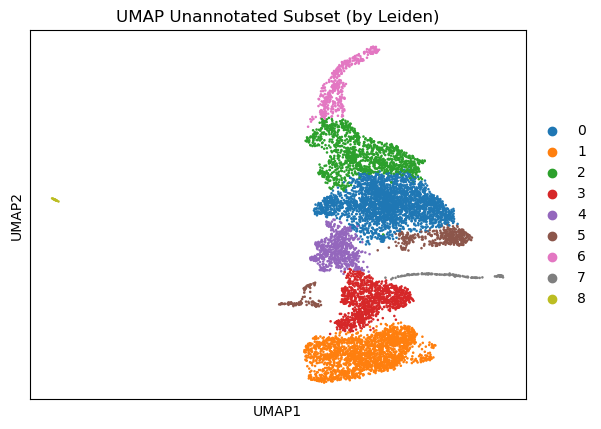

In [7]:
sc.pl.umap(unannotated_cells, color=['leiden'], title="UMAP Unannotated Subset (by Leiden)")


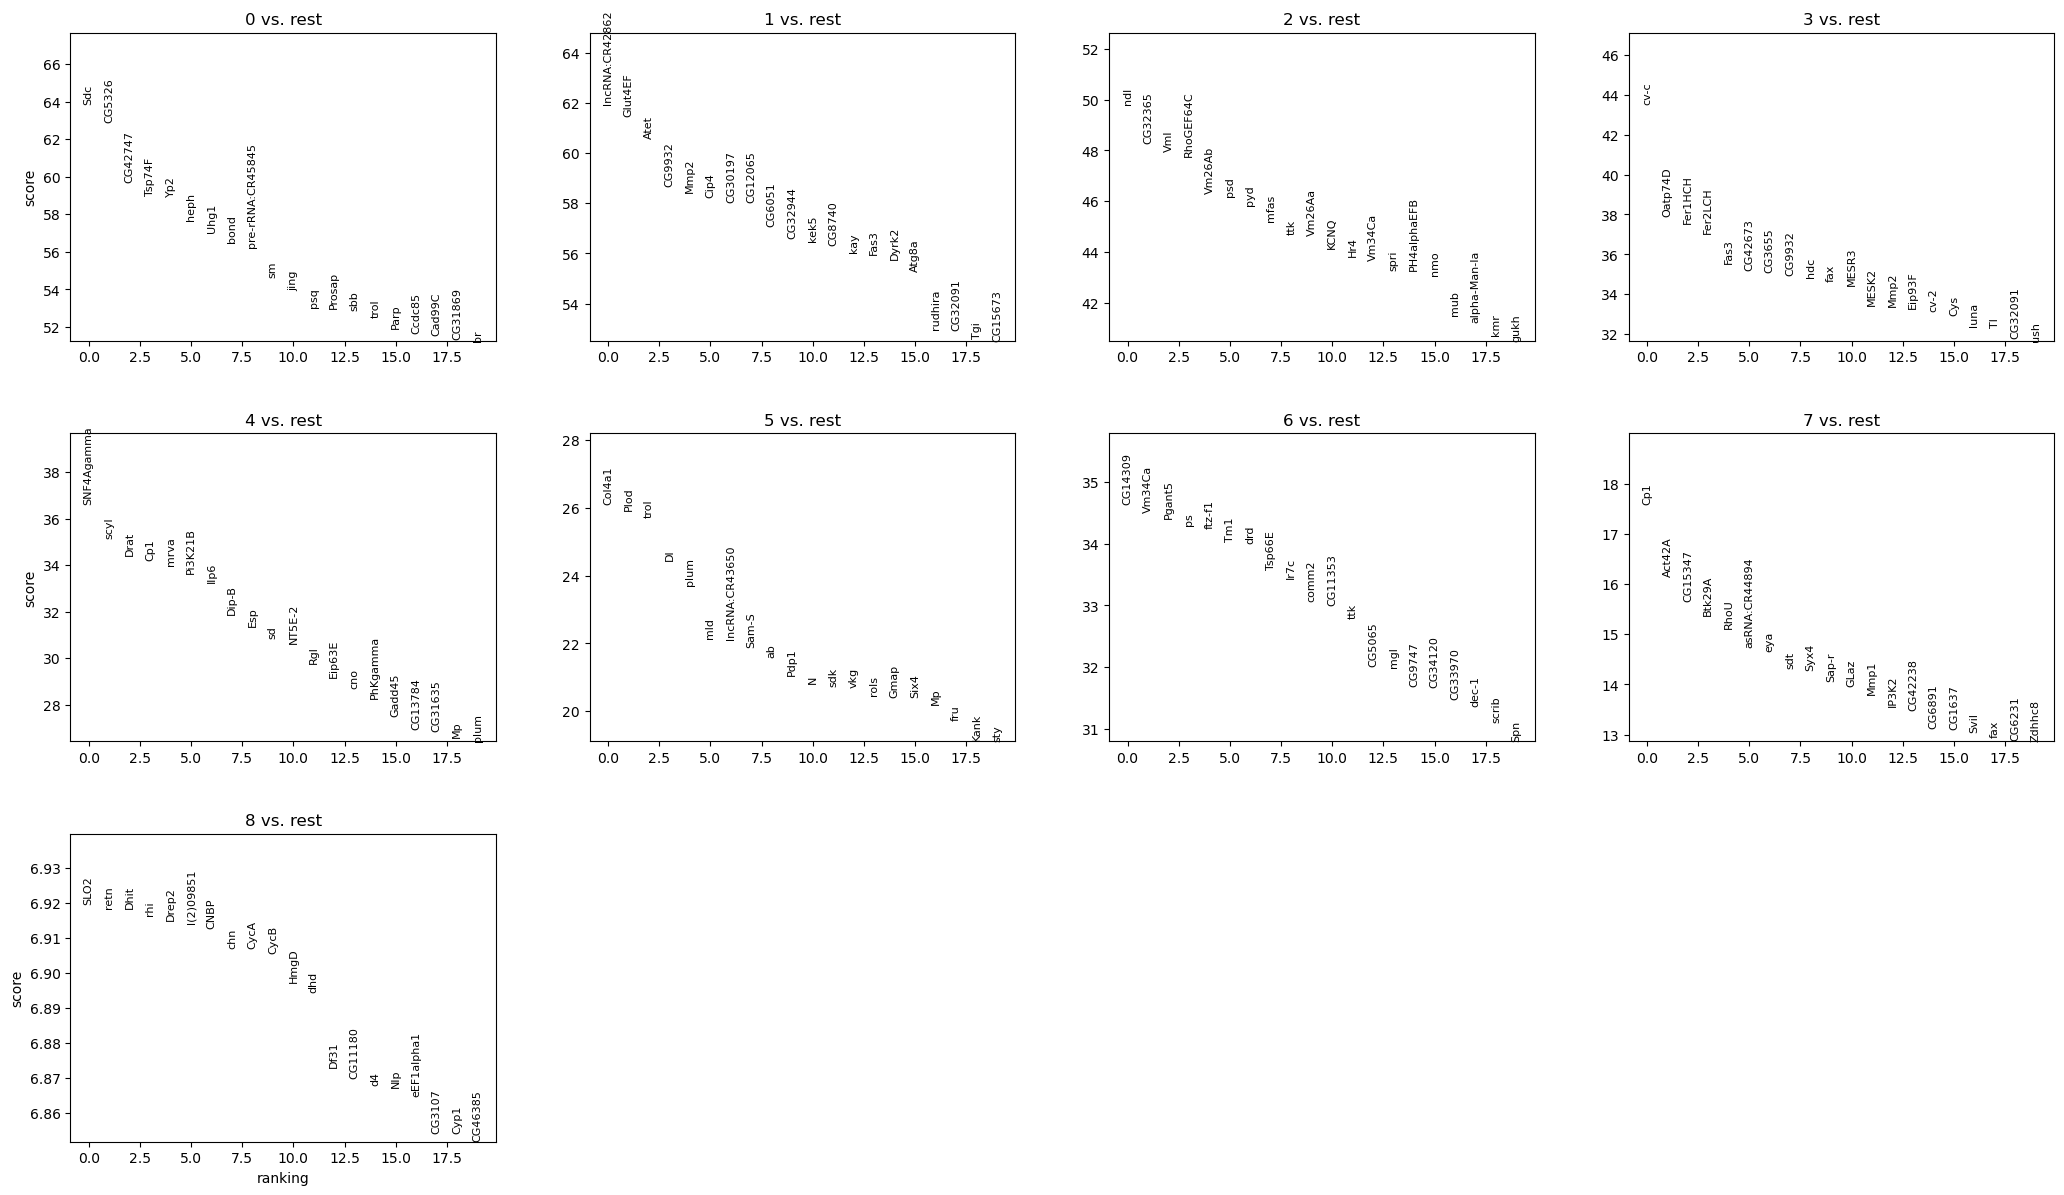

In [8]:
sc.tl.rank_genes_groups(
    unannotated_cells, 
    groupby='leiden', 
    method='wilcoxon', 
    use_raw=True  # Adjust if you already have raw or another layer
)
sc.pl.rank_genes_groups(unannotated_cells, n_genes=20, sharey=False)


In [10]:
# Assuming you already did sc.tl.rank_genes_groups(...)
# Extract all the results and create a DataFrame.
df_markers = sc.get.rank_genes_groups_df(unannotated_cells, group=None)

# Save to CSV
df_markers.to_csv("markers_all_clusters-leiden.csv", index=False)


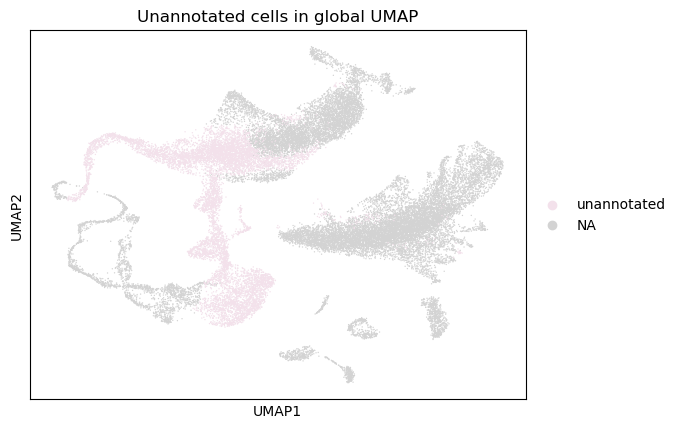

In [11]:
# This UMAP uses the embedding that already exists in adata (it does not recalculate anything).
sc.pl.umap(
    adata, 
    color='annotation',           # This paints the cells according to their annotation
    groups=['unannotated'],       # To highlight or display only those categories
    title="Unannotated cells in global UMAP"
)


# copy the new remapping or splitting of the unannotated cluster to join it to the original umap.

In [12]:
# we rename the column 'leiden' of the subset so as not to confuse it
unannotated_cells.obs['sub_leiden'] = unannotated_cells.obs['leiden']

# Copy that annotation from unannotated_cells.obs to adata.obs
adata.obs.loc[unannotated_cells.obs_names, 'sub_leiden'] = unannotated_cells.obs['sub_leiden']


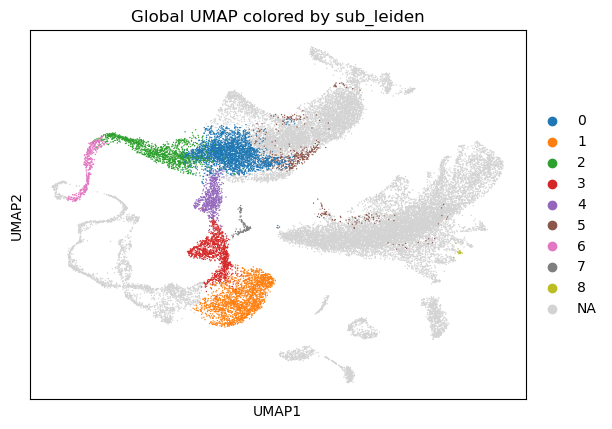

In [13]:
sc.pl.umap(
    adata, 
    color='sub_leiden', 
    title='Global UMAP colored by sub_leiden'
)


In [23]:
# When creating annotation_merged, convert it to string
adata.obs['annotation_merged'] = adata.obs['annotation'].astype(str)

mask_unann = adata.obs['annotation'] == 'unannotated'

# We also convert sub_leiden to str (optional, but may avoid conflicts)
adata.obs['sub_leiden'] = adata.obs['sub_leiden'].astype(str)

# Now we assign
adata.obs.loc[mask_unann, 'annotation_merged'] = adata.obs.loc[mask_unann, 'sub_leiden']

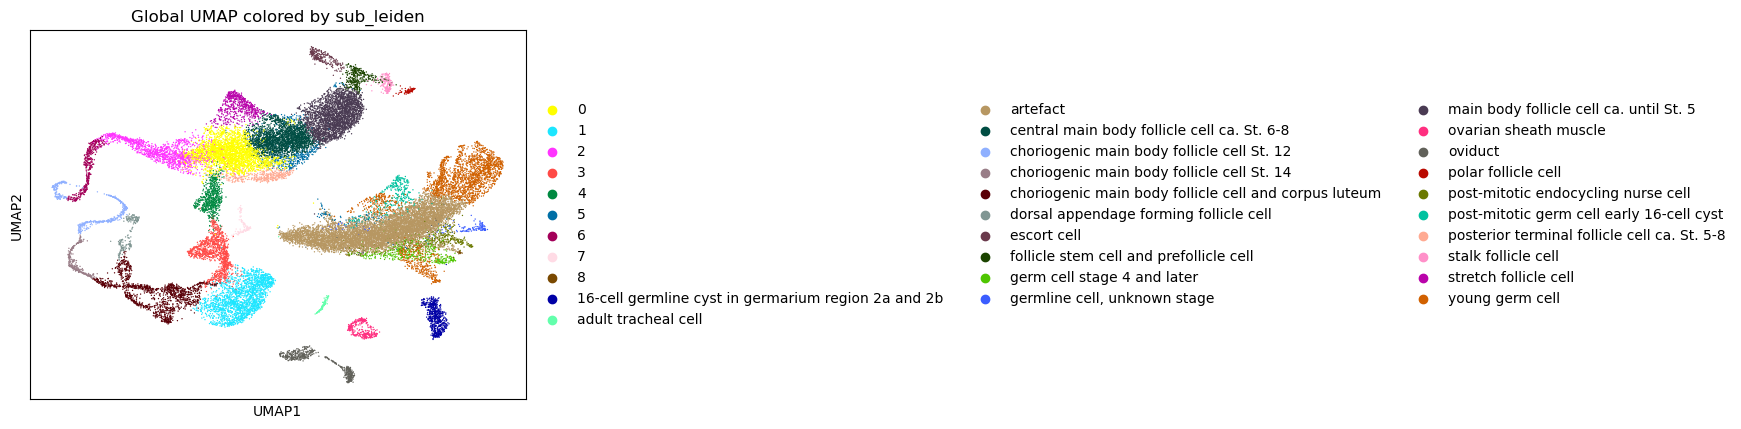

In [25]:
sc.pl.umap(
    adata, 
    color='annotation_merged', 
    title='Global UMAP colored by sub_leiden'
)

## CHECKING ANNOTATIONS WITH MARKER GENES

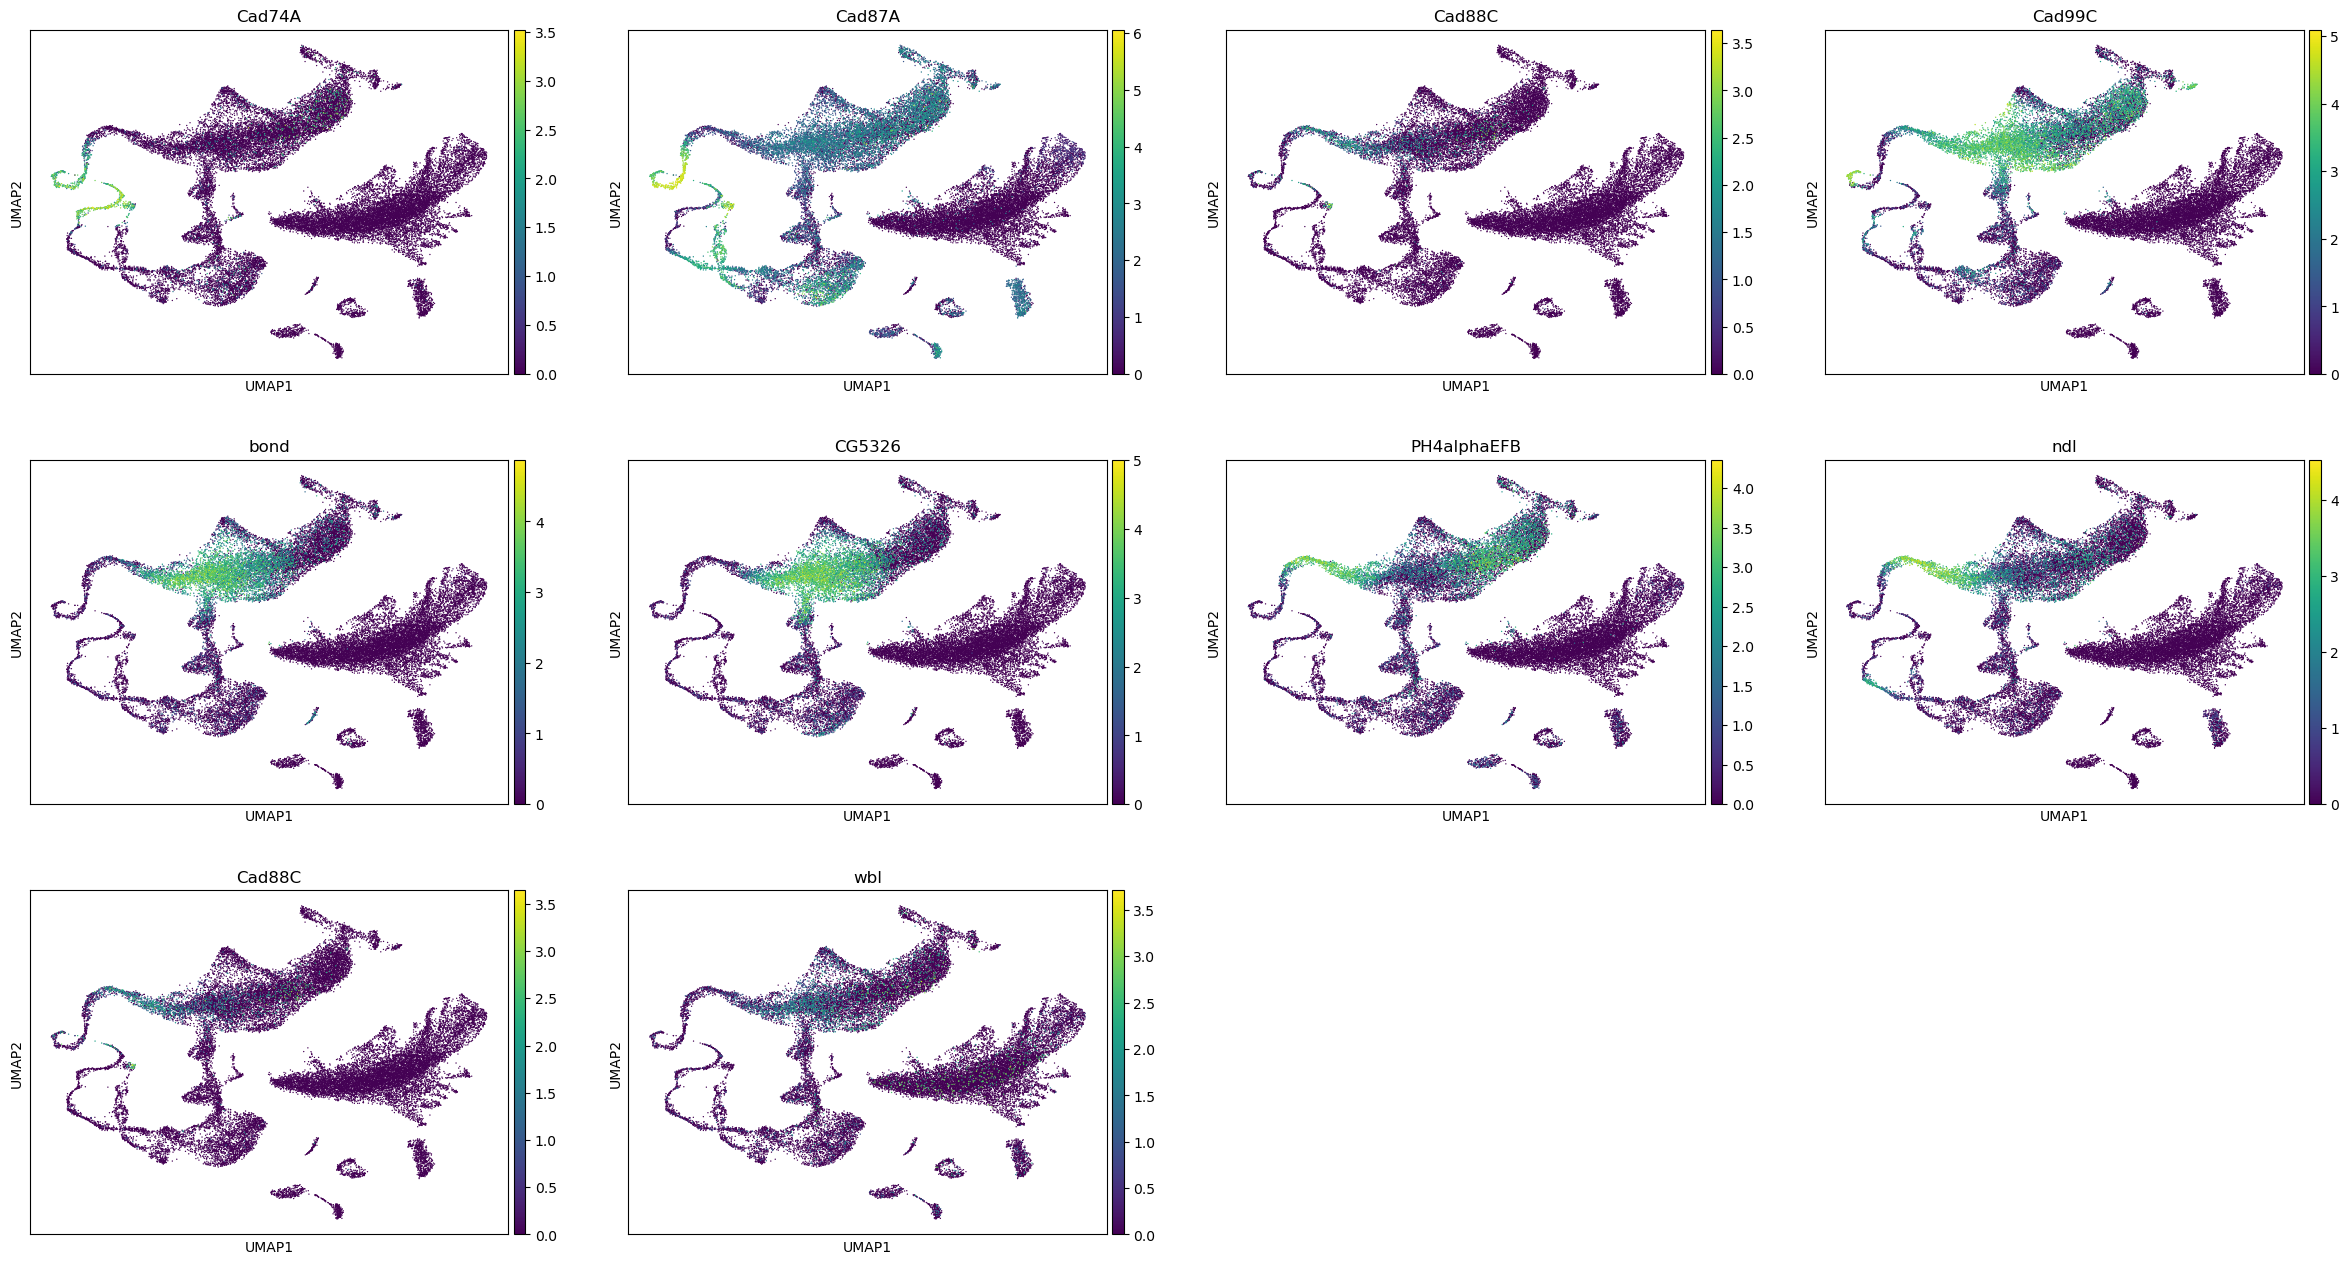

In [27]:
sc.pl.umap(
    adata,
    color= ['Cad74A', 'Cad87A','Cad88C','Cad99C','bond','CG5326','PH4alphaEFB','ndl','Cad88C','wbl']
)


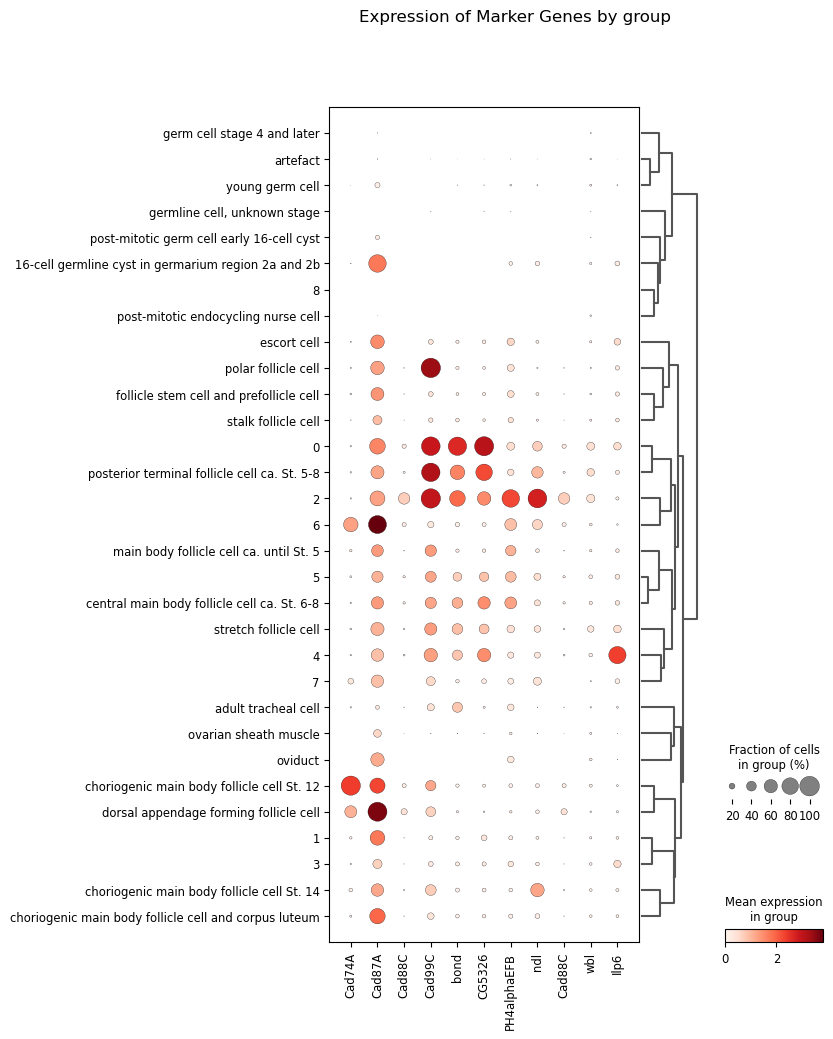

In [28]:
sc.pl.dotplot(
    adata,
    var_names=['Cad74A', 'Cad87A','Cad88C','Cad99C','bond','CG5326','PH4alphaEFB','ndl','Cad88C','wbl', 'Ilp6'],
    groupby="annotation_merged",
    dendrogram= 'TRUE', #turn off by clustering
    title="Expression of Marker Genes by group"
)

## CHANGING NAME OF NEW ANNOTATION AND MERGING ANNOTATION

In [31]:
# Defines the mapping dictionary for cells originally “unannotated”.
mapping = {
    "0": "Stage 9",
    "2": "Stage 10A",
    "6": "Stage 10B/11",
    "4": "adipocytes"
}

# Creates the mask for cells that are originally “unannotated”.
mask_unann = adata.obs['annotation'] == 'unannotated'

# Make sure that 'annotation_merged' is of type Categorical
if not pd.api.types.is_categorical_dtype(adata.obs["annotation_merged"]):
    adata.obs["annotation_merged"] = adata.obs["annotation_merged"].astype("category")

# Add to the set of categories the new tags if they do not exist yet.
new_cats = list(mapping.values()) + ["unannotated"]
adata.obs["annotation_merged"] = adata.obs["annotation_merged"].cat.add_categories(new_cats)

# Now apply the mapping on the filtered cells.
adata.obs.loc[mask_unann, 'annotation_merged'] = adata.obs.loc[mask_unann, 'annotation_merged'].apply(
    lambda x: mapping.get(x, "unannotated")
)

# Verify the final distribution of 'annotation_merged'.
print("Final distribution of annotation_merged:")
print(adata.obs['annotation_merged'].value_counts())


Final distribution of annotation_merged:
annotation_merged
artefact                                                 7918
unannotated                                              3745
main body follicle cell ca. until St. 5                  2799
Stage 9                                                  2741
young germ cell                                          2433
central main body follicle cell ca. St. 6-8              2324
choriogenic main body follicle cell and corpus luteum    1444
Stage 10A                                                1243
adipocytes                                                670
16-cell germline cyst in germarium region 2a and 2b       628
stretch follicle cell                                     587
oviduct                                                   580
choriogenic main body follicle cell St. 12                476
Stage 10B/11                                              426
germ cell stage 4 and later                               420
post-mitoti

C:\Users\omcn8\AppData\Local\Temp\ipykernel_17080\211139010.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs["annotation_merged"]):


## DELETING OLD NAMES OF NEW ANOTATION

In [34]:
# First, we remove the categories that do not have cells using remove_unused_categories()
adata.obs["annotation_merged"] = adata.obs["annotation_merged"].cat.remove_unused_categories()

# If you want to explicitly delete those categories that are known and have zero cells,
# define the list of categories to delete:
to_remove = ['0','1','2','3','4','5','6','7','8']

# Filter the existing categories to keep only those that actually have cells and are not in to_remove
new_categories = [cat for cat in adata.obs["annotation_merged"].cat.categories if cat not in to_remove]

# Update the column “annotation_merged” defining the new categories
adata.obs["annotation_merged"] = adata.obs["annotation_merged"].cat.set_categories(new_categories)

# Verify the final distribution
print("Final distribution of annotation_merged:")
print(adata.obs["annotation_merged"].value_counts())


Final distribution of annotation_merged:
annotation_merged
artefact                                                 7918
unannotated                                              3745
main body follicle cell ca. until St. 5                  2799
Stage 9                                                  2741
young germ cell                                          2433
central main body follicle cell ca. St. 6-8              2324
choriogenic main body follicle cell and corpus luteum    1444
Stage 10A                                                1243
adipocytes                                                670
16-cell germline cyst in germarium region 2a and 2b       628
stretch follicle cell                                     587
oviduct                                                   580
choriogenic main body follicle cell St. 12                476
Stage 10B/11                                              426
germ cell stage 4 and later                               420
post-mitoti

## PLOTTING FINAL UMAP

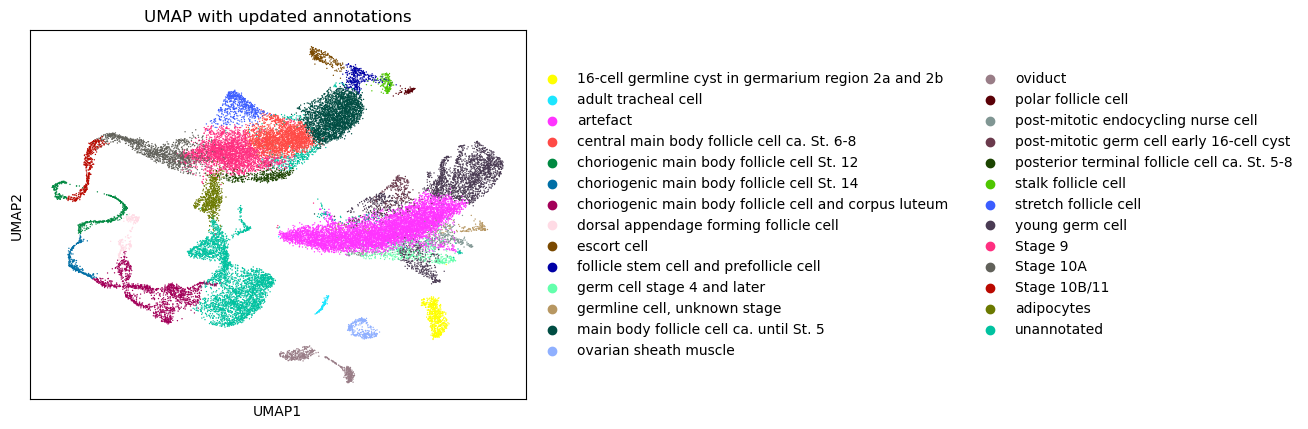

In [37]:
# Finally, you can graph the UMAP
sc.pl.umap(adata, color='annotation_merged', legend_loc="right margin", title="UMAP with updated annotations")

C:\Users\omcn8\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\omcn8\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\omcn8\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\omcn8\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\omcn8\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.l

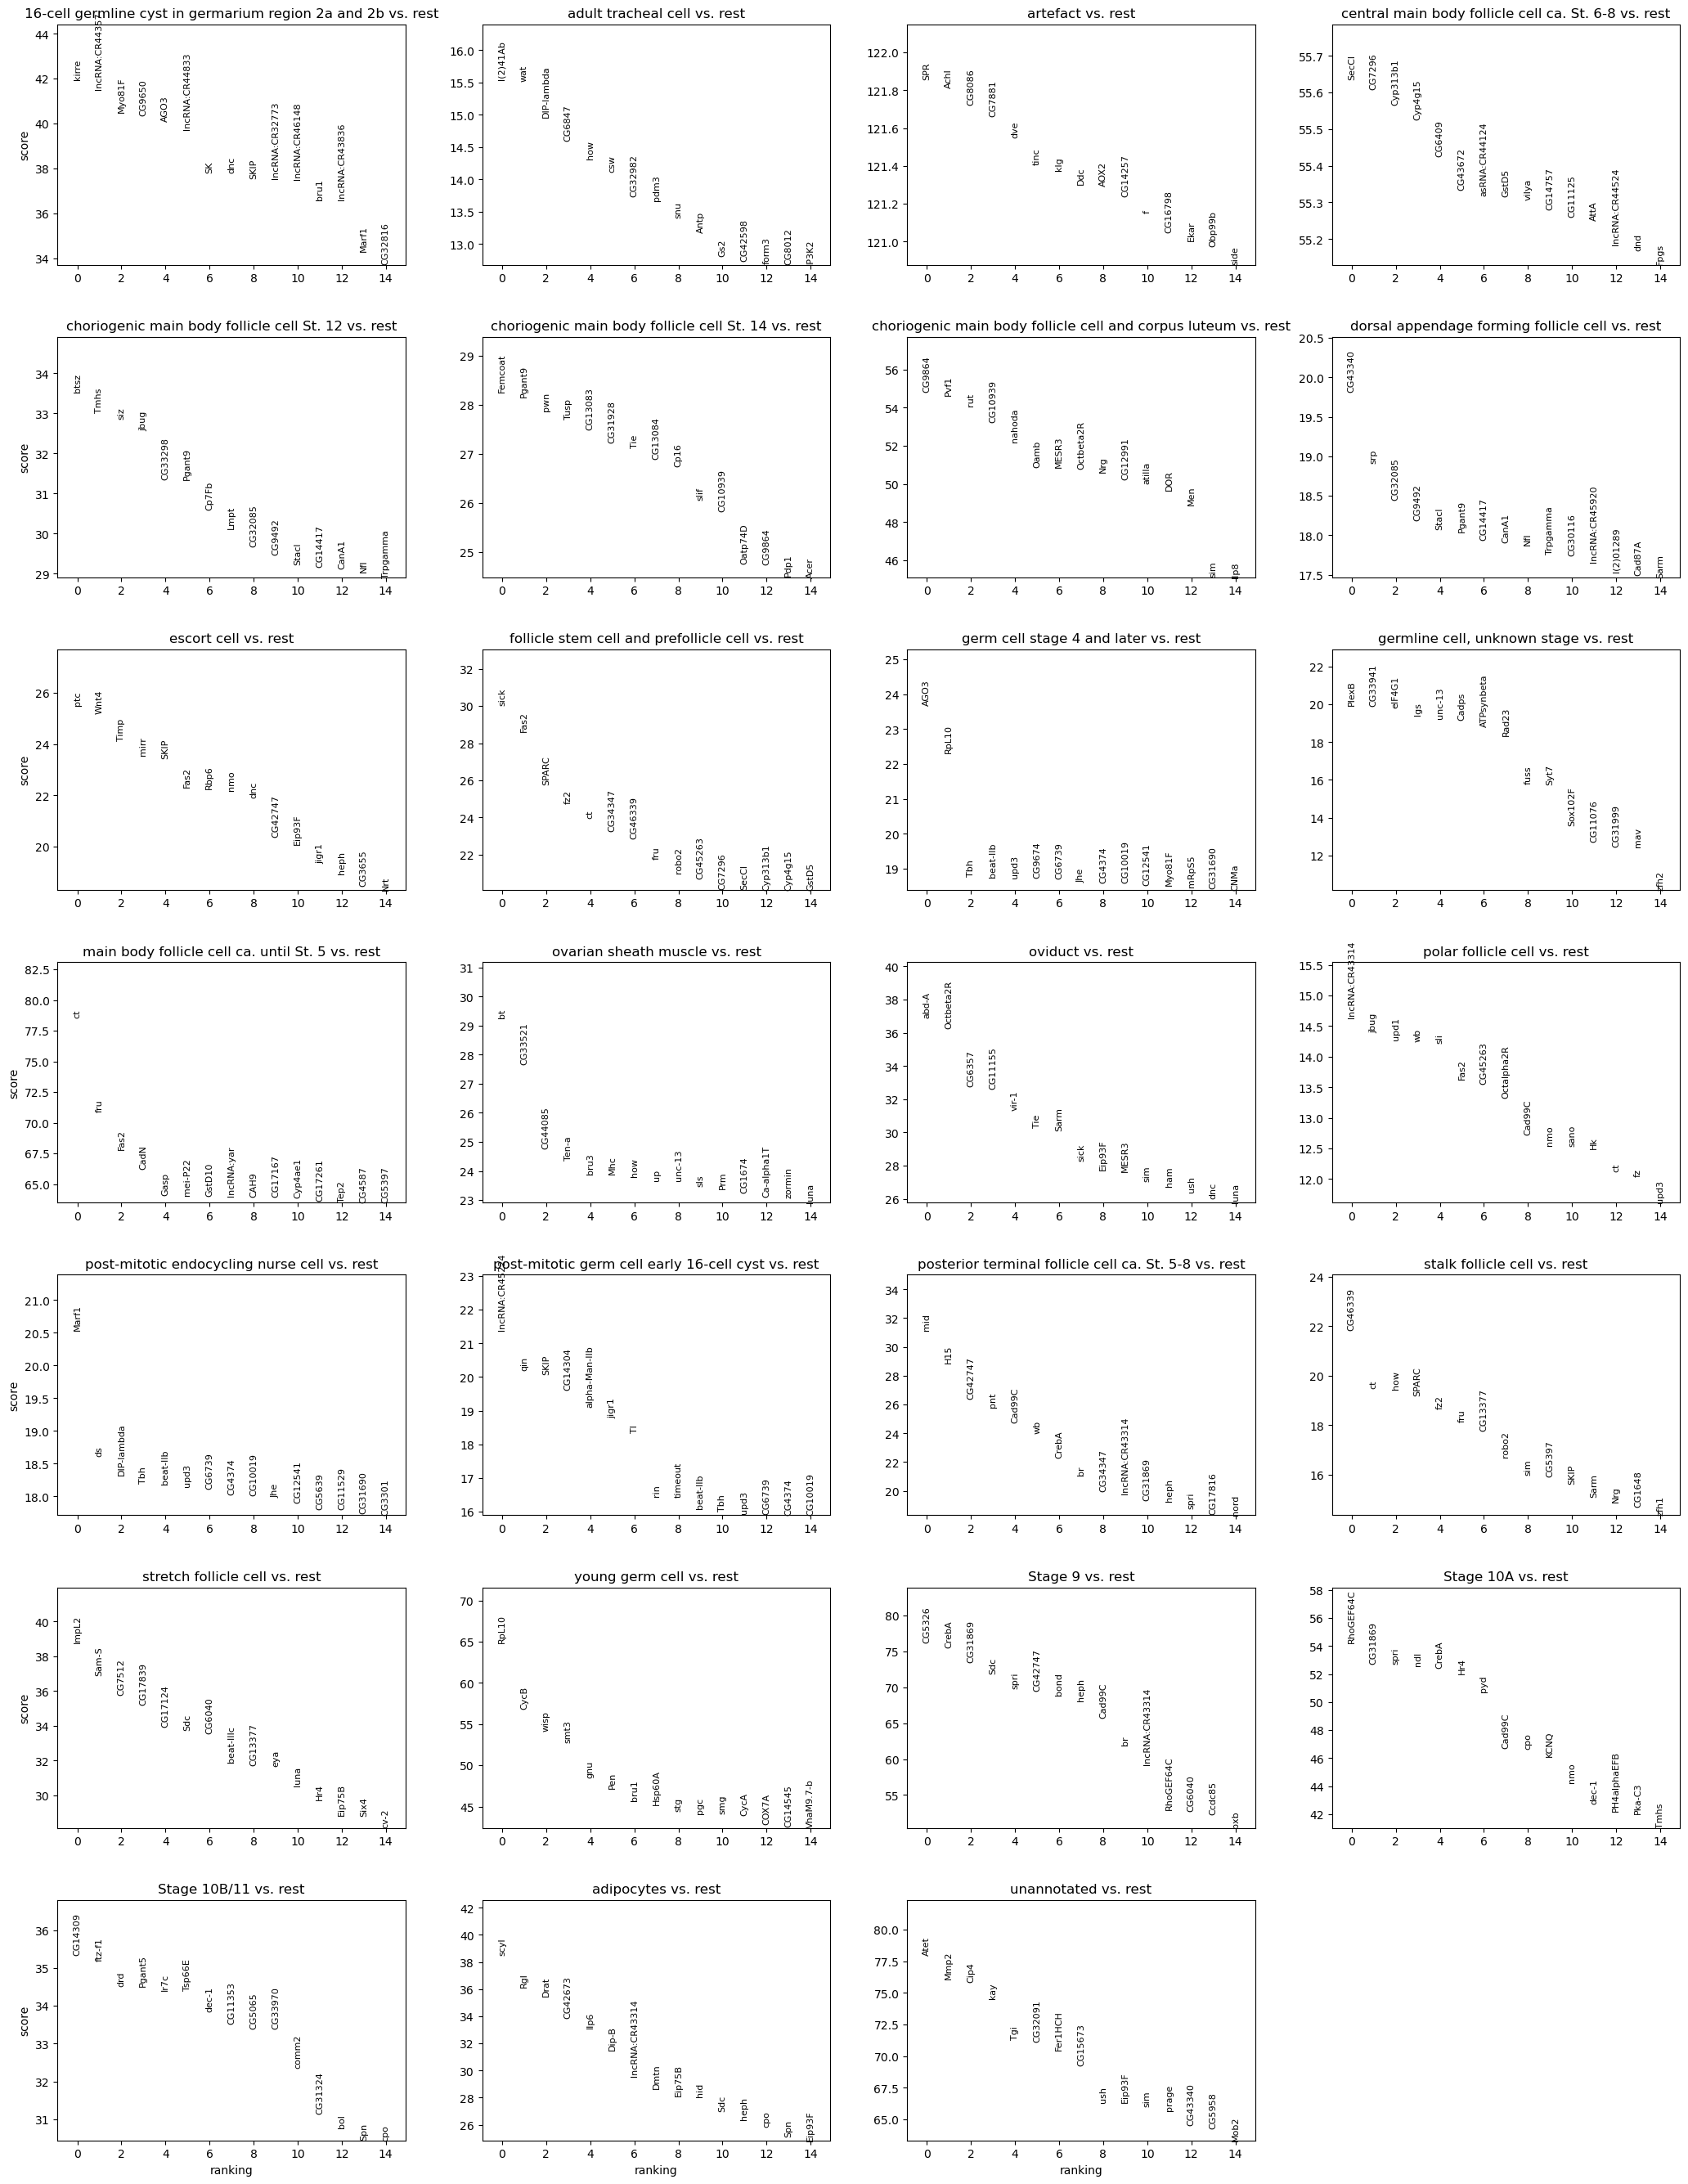

In [49]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='annotation_merged', 
    method='wilcoxon', 
    use_raw=False  # Ajustar si ya tienes raw u otra capa
)
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

# Asumiendo que ya hiciste sc.get.rank_genes_groups_df(...)
# Extraer todos los resultados y crear un DataFrame
df_markers = sc.get.rank_genes_groups_df(adata, group=None)

# Guardar en CSV
df_markers.to_csv("markers_all_clusters-leiden.csv", index=False)


## Save results .h5ad

In [ ]:
# Supongamos que tu objeto se llama 'adata'
adata.write("ovary_flycellatlas.h5ad")


# Versions and packages used in these analyses

In [ ]:
import sys
import platform
import pkg_resources
import subprocess

# 1. Versión de Python
print("Python version:", sys.version)

# 2. Versión de Jupyter Notebook
try:
    import notebook
    print("Jupyter Notebook version:", notebook.__version__)
except ImportError:
    print("Jupyter Notebook not installed")

# 3. Información del sistema operativo
print("Operating System:", platform.system(), platform.release())
print("Machine:", platform.machine())

# 4. Paquetes instalados (pip freeze o pkg_resources)
print("\nInstalled packages:")
for dist in sorted(pkg_resources.working_set, key=lambda x: x.project_name.lower()):
    print(f"{dist.project_name}=={dist.version}")
